## Import library

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications

## Dataset

### Load cifar10

In [2]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() #載入cifar到程式中

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
print("train data:",'images:',x_train.shape,
      " labels:",y_train.shape)
print("test  data:",'images:',x_test.shape ,
      " labels:",y_test.shape)

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


### Normalize

In [4]:
#把0-255的像素轉換到1 ~ -1之間，並將大小調整為96*96
x_train_norm = tf.image.resize(x_train / 127.5 - 1.0, [96, 96])
x_test_norm = tf.image.resize(x_test / 127.5 - 1.0, [96, 96])

In [5]:
x_train_norm.shape

TensorShape([50000, 96, 96, 3])

### One hot encode

In [6]:
#進行One hot encode 作為label
y_train_OneHot = to_categorical(y_train)
y_test_OneHot = to_categorical(y_test)

## Data Argument

In [7]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"), #水平與垂直翻轉
])

## Model

In [8]:
#模型使用Pretrained MoblieNetV2
backbone = applications.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
backbone.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Transfer Learning

In [10]:
#凍結ImageNet的前一百層
for layer in backbone.layers[:100]:
  layer.trainable = False

### Classification Layer

In [12]:
classification = model = tf.keras.models.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(), #5x5 Average pooling
    tf.keras.layers.Flatten(), #轉為一維
    tf.keras.layers.Dropout(0.5), #Dropout設為50%
    tf.keras.layers.Dense(128, activation='relu'), #輸出128的全連接層，使用relu
    tf.keras.layers.Dense(10, activation='softmax') #將輸入轉換成10個類別的機率
])

In [13]:
model = tf.keras.models.Sequential([
    data_augmentation, #資料擴增
    backbone, #MoblileNet
    classification #分類層
])

In [16]:
#加入了data augmentation的model無法summary
sum_model = tf.keras.models.Sequential([
    backbone,
    classification
])

In [17]:
sum_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 sequential_1 (Sequential)   (None, 10)                165258    
                                                                 
Total params: 2,423,242
Trainable params: 2,026,698
Non-trainable params: 396,544
_________________________________________________________________


### Load weight



In [18]:
try:
    model.load_weights("./cifarCnnModel.h5")
    print("載入模型成功!繼續訓練模型")
except :
    print("載入模型失敗!開始訓練一個新模型")

載入模型失敗!開始訓練一個新模型


## Training


In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #用 adam 優化器，學習率10^-4

In [20]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', #指定損失函式
              metrics=['accuracy']) #評估指標用「正確度(答對的比率)」

In [21]:
train_history = model.fit(x_train_norm, y_train_OneHot,
                          validation_split=0.2, #20%的測試資料拿去當驗證集
                          epochs=10, #訓練：10 epochs (訓練資料跑完十次)
                          batch_size=128, #一次讀進的資料量
                          verbose=1) #進度條

Epoch 1/10
313/313 [==============================] - 32s 29ms/step - loss: 0.9290 - accuracy: 0.6879 - val_loss: 0.5232 - val_accuracy: 0.8269
Epoch 2/10
313/313 [==============================] - 7s 24ms/step - loss: 0.5079 - accuracy: 0.8287 - val_loss: 0.4023 - val_accuracy: 0.8648
Epoch 3/10
313/313 [==============================] - 8s 25ms/step - loss: 0.3957 - accuracy: 0.8640 - val_loss: 0.4301 - val_accuracy: 0.8587
Epoch 4/10
313/313 [==============================] - 8s 25ms/step - loss: 0.3261 - accuracy: 0.8887 - val_loss: 0.4674 - val_accuracy: 0.8520
Epoch 5/10
313/313 [==============================] - 8s 24ms/step - loss: 0.2690 - accuracy: 0.9076 - val_loss: 0.3792 - val_accuracy: 0.8784
Epoch 6/10
313/313 [==============================] - 7s 24ms/step - loss: 0.2361 - accuracy: 0.9178 - val_loss: 0.4356 - val_accuracy: 0.8639
Epoch 7/10
313/313 [==============================] - 7s 24ms/step - loss: 0.2034 - accuracy: 0.9290 - val_loss: 0.4154 - val_accuracy: 0.874

### Accuracy

In [22]:
def show_acc_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

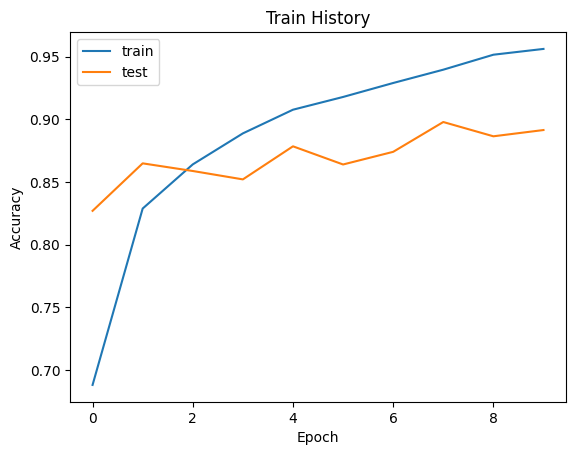

In [23]:
show_acc_train_history('accuracy','val_accuracy')

### Loss

In [24]:
def show_loss_train_history(train_loss,test_loss):
    plt.plot(train_history.history[train_loss])
    plt.plot(train_history.history[test_loss])
    plt.title('Train History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

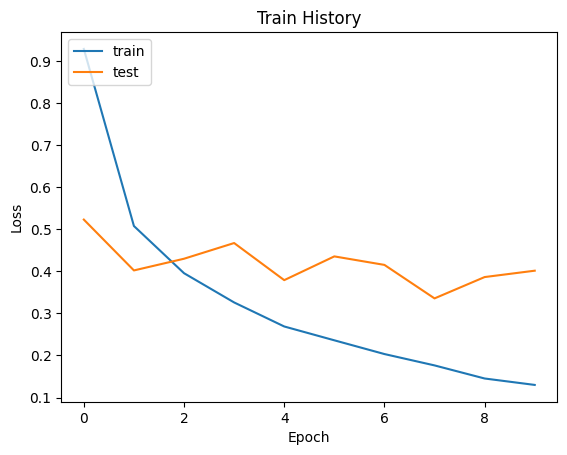

In [25]:
show_loss_train_history('loss','val_loss')

## Test

In [26]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

### On test set

In [27]:
loss, acc = model.evaluate(x_test_norm,  y_test_OneHot, verbose=0) #評估測試組的平均損失與正確率
print("Loss:", loss)
print("Accuracy", acc)

Loss: 0.43936362862586975
Accuracy 0.8810999989509583


In [28]:
prediction=np.argmax(model.predict(x_test_norm), axis=-1)
prediction[:10]

313/313 [==============================] - 3s 7ms/step


array([3, 8, 1, 0, 6, 6, 1, 6, 3, 1])

### Have a glance

In [29]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,
                                  idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx],cmap='binary')

        title=str(i)+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[i]]

        ax.set_title(title,fontsize=10)
        ax.set_xticks([]);ax.set_yticks([])
        idx+=1
    plt.show()

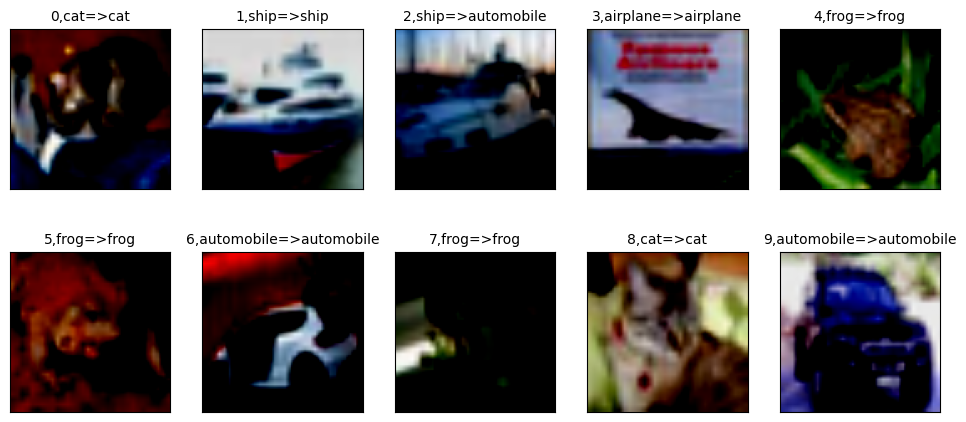

In [30]:
plot_images_labels_prediction(x_test_norm, y_test,
                              prediction,0,10)

In [31]:
Predicted_Probability=model.predict(x_test_norm)

313/313 [==============================] - 2s 6ms/step


### Single image

In [34]:
def show_Predicted_Probability(y,prediction,
                               x_img,Predicted_Probability,i):
    print('label:',label_dict[y[i][0]],
          'predict:',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_test_norm[i],(96, 96,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j]+
              ' Probability:%1.9f'%(Predicted_Probability[i][j]))

label: cat predict: cat


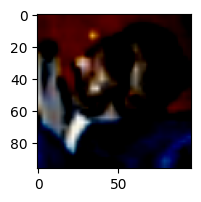

airplane Probability:0.000000140
automobile Probability:0.000000235
bird Probability:0.000000077
cat Probability:0.995759189
deer Probability:0.000000676
dog Probability:0.004193512
frog Probability:0.000045904
horse Probability:0.000000180
ship Probability:0.000000083
truck Probability:0.000000072


In [35]:
show_Predicted_Probability(y_test,prediction,
                           x_test_norm,Predicted_Probability,0)

### Confusion matrix

In [36]:
import pandas as pd
print(label_dict)
pd.crosstab(y_test.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,885,18,13,5,6,1,7,5,49,11
1,2,979,0,0,0,0,2,0,6,11
2,19,2,835,39,20,16,63,3,3,0
3,4,9,9,777,17,94,70,5,11,4
4,6,3,30,27,802,29,46,51,4,2
5,4,3,9,104,10,829,27,11,2,1
6,3,1,1,6,2,4,982,0,1,0
7,8,2,10,16,18,29,12,897,5,3
8,18,15,1,2,0,0,5,0,957,2


## Save weight

In [37]:
model.save_weights("./cifarCnnModel.h5")